# Analysis of Historic Storm Data

In this analysis, I investigated historical storm data from the National Centers for Environmental Information from NOAA. The Storm Events Database covers the time period between January 1950 to September 2023, at this time. The database was created to document significant weather phenomena with damage to people, property or commerce, unusual weather events, and significant meteorlogical events. The csv of the Storm Events Database can be found at https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/. For the purposes of this analysis, I have chosen to focus on the Storm Events Details published December 17, 2023 (StormEvents_details-ftp_v1.0_d2023_c20231217.csv.gz)

The event types collected have changed over time. During the period from 1950 to 1955, data was collected on tornados. From 1955 to January 1996, event data was collected for Tornado, Thunderstorm, Wind, and Hail events. From January 1996 to September 2023, event data was collected on 48 event types as detailed by the National Weather Service in instruction 10-1605 (https://www.nws.noaa.gov/directives/sym/pd01016005curr.pdf)

#### Set Up
- Import libraries
- Set display options
- Import Storm Events CSV
- Set column names to lower case
 


In [186]:
#import py libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import statsmodels.api as sm

In [187]:
#set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.0f}'.format

In [188]:
#import storm data csv
storms = pd.read_csv("StormEvents_dedup.csv").reset_index()
#set column names to lowercase for python coding
storms.columns = storms.columns.str.lower()

/tmp/ipykernel_11744/4145212813.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,10,11,15,21,22,23,24,27,28,29,30,31,33,34,35,36,37,38,39,42,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  storms = pd.read_csv("StormEvents_dedup.csv").reset_index()


In [189]:
#import shapefile for maping usa data in geopandas
usa_map = gpd.read_file('states.shp')
usa_map.columns = usa_map.columns.str.lower()
usa_map.rename(columns={'state_name':'state'}, inplace=True)
usa_map['state']=usa_map['state'].str.lower()

In [190]:
#remove line with header from cvs join
storms = storms[storms['year']!='YEAR'].reset_index()

In [191]:
#set dtype for 'years'
storms['year'] = storms['year'].astype(int)

#### Data Set Overview
The weather event dataset includes 1,630,114 unique entries of weather significant weather events from January 1996 to September 2023. It is organized by Episode and Event, where an episode may be comprised of several meoterological events with unique event types, while still belonging to the same primary meteorological episode. It includes columns for:
  - Event beginning and ending year and month, day, and time, and a column for a combined datetime each for beginning and ending
  - Event location with State, State id, regional type (county, parish, etc), regional id, and regional name, event beginning and ending locations, beginning and ending latitude and longitude, and beginning/ending azimuth directions
  - Event scale details for tornados including scale, length, width, magnitude type, flood_cause
  - Event impact with columns for injuries direct and indirect, deaths direct and indirect, property damage, and crop damage
  - Data source
  - Episode and Event narrative descriptions

The dimensions of the dataset include the date/time information and the location data. The measures include both categorical measures of event type, event magnitude descriptors, episode narratives, event narratives, and reporting source. The numeric measures include numbers of injuries and deaths, and cost of damage to property and crops. 

#### Exploration Questions: Weather Event Frequency
Weather event frequency over time:
- How many extreme weather events occur in a year?
- Are extreme weather events occuring more frequently?
- What does the frequency of weather events look like in each state over time?
- What is the most frequent event type by year?


In [192]:
#select data subset of state, date, and event_type
storm_ev = storms[['begin_yearmonth', 'event_id', 'state', 'year', 'month_name', 'event_type',]].reset_index()

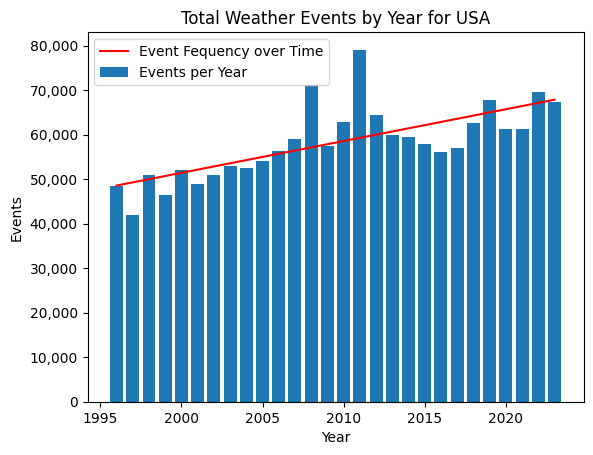

[47713, 66991, 86269]


In [193]:
#total weather event by year
events_year = storm_ev.groupby('year')['event_id'].count().reset_index()
events_year = events_year.rename(columns={'year':'year', 'event_id':'num_events'})
#plot events by year
plt.figure()
ax = plt.subplot(1,1,1)
plt.bar(events_year['year'], events_year['num_events'], label = 'Events per Year')
y_ticks = list(range(0,100000,10000))
ax.set_yticks(y_ticks)
ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_ticks])
#create best fit model
x_data = events_year['year']
y_data = events_year['num_events']
model = sm.OLS.from_formula('y_data~x_data', data = events_year)
results = model.fit()
#print(results.params)
#plot best fit model line
plt.plot(events_year['year'], results.predict(events_year), color = 'r', label = 'Event Fequency over Time')
plt.title('Total Weather Events by Year for USA')
plt.xlabel('Year')
plt.ylabel('Events')
plt.legend(loc = 2)
plt.show()
#inputs into best fit formula
fit_years = [1996, 2023, 2050]
fit_events =[714*y-1377431 for y in fit_years]
print(fit_events)

The above graph and best fit, least squares regression line is startling because of the dramatic,  linear increase in notable weather events in the USA, in just the last 30 years. The line has a formula of $E=714Y-1377431$. 
Based on this historic trend, if factors influencing weather patterns remain the same, we should expect to see more frequent weather events each year. Moving from a predicted 48K events in 1996, to 65K in 2023, to 86K in 2050, an increase of 28.8% over 30 years. 

#### Is the increase in weather events uniform over all 50 states or does it vary between states?

The increase in weather events is not distributed evenly across all fifty states. As can be seen in the below figure, some states are seeing dramatic increases in weather events while other states are experiencing modest decreases in events. 

In [194]:
#create a function that takes a list of states and returns a dictionary of weather events by state
def state_storm_fequency (state_list):
    states_event_dict = {}
    states = map(lambda x: x.upper(), state_list)
    for state in states:
        state_events = storm_ev[['event_id', 'state', 'year', 'month_name', 'event_type']][storm_ev['state']== state].reset_index()
        states_event_dict [state]= state_events
    return states_event_dict

In [195]:
##using the state_event_dict, created by the state_storm_frequency function, produce graphs of the event frequency for each state by year
def event_graph_by_state (state_list,state_dict):
    states = map(lambda x: x.upper(), state_list)
    states_plt_dict = {}
#create graph info per state
    n = 0
    plt.figure(figsize=(8,100), layout = 'constrained')
#create state_graph_dictionary
    for state in states:
        state_graph ={}
        events_year = storm_ev.groupby('year')['event_id'].count().reset_index()
        events_year = events_year.rename(columns={'year':'year', 'event_id':'num_events'})
        df = state_dict[state]
        states_year = df.groupby('year')['event_id'].count().reset_index()
        states_year = states_year.rename(columns={'year':'year', 'event_id':'num_events'})
        graph_lable = 'Events per Year in '+str(state).title()
#create best fit model amd line
        x_data = states_year['year']
        y_data = states_year['num_events']
        model = sm.OLS.from_formula('y_data~x_data', data = states_year)
        results = model.fit()
        #print(results.params[1])
        bf_predict = results.predict(states_year)
        n+=1
        state_graph = {'bar_x':x_data,'bar_y':y_data, 'bar_label':graph_lable, 'state_rate' : results.params[1], 'best_data' : x_data, 'best_pred':bf_predict }
        states_plt_dict[state]=state_graph
#plot bar and line graphs
        y_ticks = range(0,7500,250)
        #y_ticks = (np.linspace(0,states_year['num_events'].max(), 10))
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(['{:,.0f}'.format(x) for x in y_ticks])
        plt.subplot(25,2,n)
        plt.bar(x_data, y_data, label=graph_lable)
        plt.plot(x_data,bf_predict,color ='r',label ='Event Frequency Rate of Change')
        plt.ylim(bottom=0, top = 7500, auto=False)
#create plot title, labels and legends
        plt.title(str(state).title())
        plt.xlabel('Year')
        plt.ylabel('Events')
        plt.legend(loc=2)
        #print the figure
    plt.show()
    plt.close('all')
#return states dictionary with printable info
    return states_plt_dict


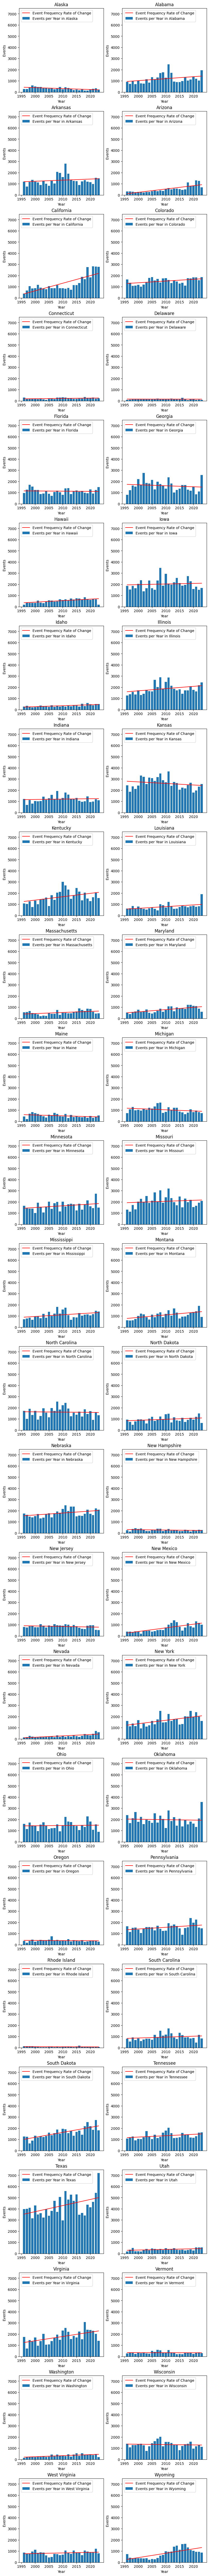

In [196]:
#call the functions to produce a graph for each state weather events by year with more than 25 events
state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
events_by_state = state_storm_fequency(state_names)
states_frequency_graph_info = event_graph_by_state(state_names, events_by_state)

#### What are the most frequent weather events in the dataset?

In any given year the most frequent weather event in the USA is either Thunderstorm/Wind or a Hail event. Since 1996 in 20 of those years the most frequent notable weather events in the USA are Thunderstorm Wind Events. The other 8 years are the most frequent events are Hail events. 

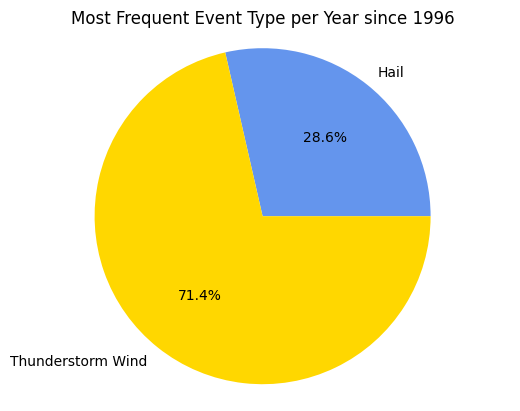

<Figure size 640x480 with 0 Axes>

In [197]:
#most frequent event type by year
years = range(1996,2024)
most_freq_by_year = pd.DataFrame(columns=['years', 'most_freq_event'])
for year in years:
    storm_data = storm_ev[storm_ev['year']==year].reset_index()
    most_freq_type = storm_data['event_type'].mode()
    data = pd.DataFrame({'years':year, 'most_freq_event':most_freq_type})
    most_freq_by_year = pd.concat([most_freq_by_year, data])
most_freq = most_freq_by_year.groupby(most_freq_by_year['most_freq_event'])['years'].nunique().reset_index()
plt.pie(most_freq['years'], labels = most_freq['most_freq_event'], autopct='%0.1f%%', colors= ['cornflowerblue', 'gold'])
plt.axis('equal')
plt.title('Most Frequent Event Type per Year since 1996')
plt.show()
plt.clf()

## Exploratory Questions: Cost of Weather Events
- When looking at cost to property or crops, which weather events are most costly?
- Which states have the highest weather related costs?

#### Set up 

Create a data subset, wrangle the data to reflect the damage cost to both property and crops and creat a new dataframe column to reflect the total cost

In [198]:
#Create a dataframe of the relevant data columns
event_cost = storms[['episode_id', 'event_id','state','year', 'month_name','event_type','damage_property', 'damage_crops']].copy().reset_index()
event_cost = pd.DataFrame(event_cost)


In [199]:
#Select subsets of the data with damage to either property or crops
events_with_prop_damage = event_cost[event_cost['damage_property'].notnull()]
events_with_crop_damage = event_cost[event_cost['damage_crops'].notnull()]
#combine those into a dataframe with any damage with cost
events_with_damage = pd.concat([events_with_prop_damage,events_with_crop_damage]).drop_duplicates().reset_index(drop=True)
#replace any lines that are 'NaN' with a value of zero
events_with_damage['damage_crops'] = events_with_damage['damage_crops'].fillna(0)
events_with_damage['damage_property'] = events_with_damage['damage_property'].fillna(0)
events_with_damage = pd.DataFrame(events_with_damage).reset_index()
#remove a line that still has headers in it from csv stitching
events_with_damage.drop([11587], inplace = True)

In [200]:
#create a function to convert values with alpha characters into floats
def value_to_float (x):
    if type(x)== float or type(x)== int:
        return x
    if len(x) == 1:
        if x == 'K' or 'M' or 'B' or 'T':
            return 0
    if 'K' in x:
        return float(x.replace('K', ''))*1000
    if 'M' in x:
        return float(x.replace('M', ''))*1000000
    if 'B' in x:
        return float(x.replace('B', ''))*1000000000
    if 'T' in x:
        return float(x.replace('T', ''))*1000000000000
    return float(x)



In [201]:
#apply value to float to the damage_property and damage_crops columns
events_with_damage['damage_crops']=events_with_damage['damage_crops'].apply(value_to_float)
events_with_damage['damage_property']=events_with_damage['damage_property'].apply(value_to_float)

In [202]:
#programatically create combined cost column
events_with_damage['damage_cost']=events_with_damage['damage_property']+events_with_damage['damage_crops']


In [203]:
#select only events with property or crop damage cost
events_with_cost = events_with_damage[events_with_damage['damage_cost']>0].copy()
events_with_cost.drop(columns=['level_0', 'index'], inplace=True)
events_with_cost['state']=events_with_cost['state'].str.lower()

Which event type has producted the highest cost since 1996?

In [204]:
#group events by total event cost
event_type_total_cost = events_with_cost.groupby(['event_type'])['damage_cost'].sum().sort_values(ascending=False).reset_index()

/tmp/ipykernel_11744/1232973578.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,20,40,60,80,100])
/tmp/ipykernel_11744/1232973578.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(event_type_total_cost['event_type'], rotation = 90)


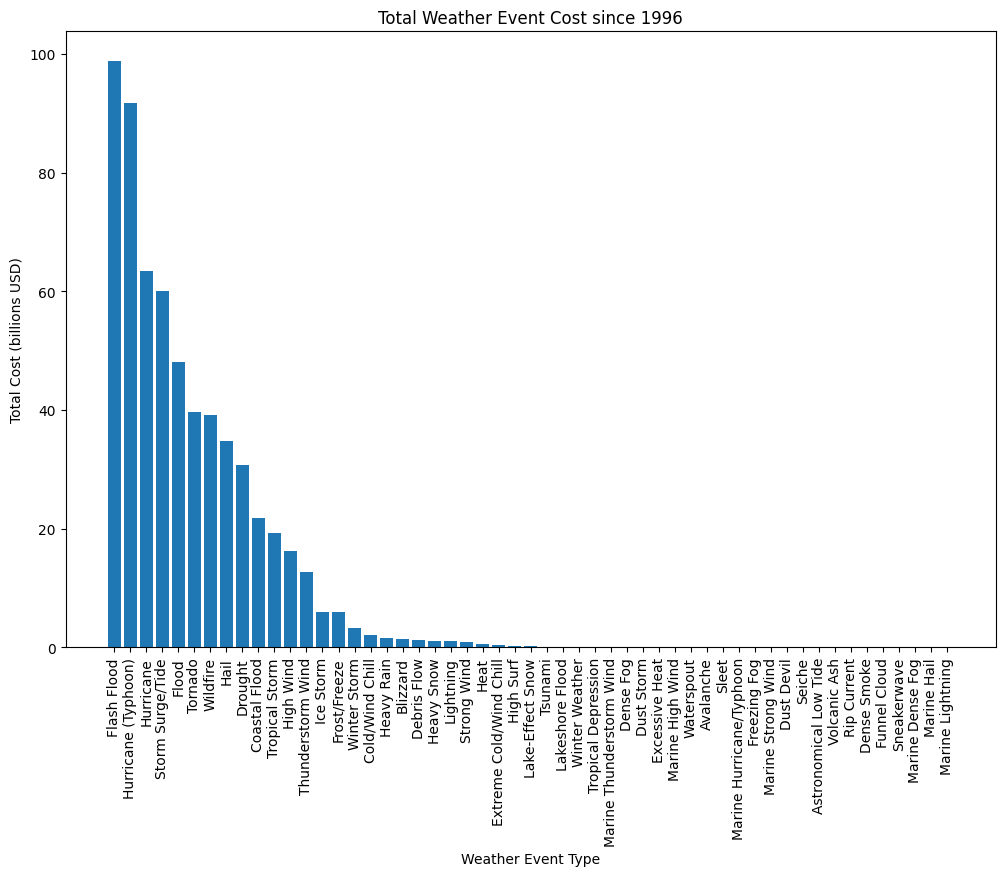

In [205]:
fig_event_cost = plt.figure(figsize=[12, 8])
ax = plt.subplot(1,1,1)
ax.set_yticklabels([0,20,40,60,80,100])
ax.set_xticklabels(event_type_total_cost['event_type'], rotation = 90)
plt.bar(event_type_total_cost['event_type'], event_type_total_cost['damage_cost'])
plt.ylabel('Total Cost (billions USD)')
plt.xlabel('Weather Event Type')
plt.title('Total Weather Event Cost since 1996')
plt.show()

In [206]:
#Find the sumerizing descriptive stats for the dataset, by state and cost
state_max_cost = events_with_cost.groupby(['state',])['damage_cost'].max().sort_values(ascending=False).reset_index()
print(state_max_cost.head())

        state    damage_cost
0   louisiana 17,900,000,000
1  california 17,000,000,000
2       texas 10,000,100,000
3     florida 10,000,000,000
4  new jersey  7,500,000,000


In [207]:
#combine data with map for mapping
state_max_cost_map = usa_map.merge(state_max_cost, on='state', how='inner')

<Axes: title={'center': 'Maximum Cost of Damages from a Weather Event by State'}>

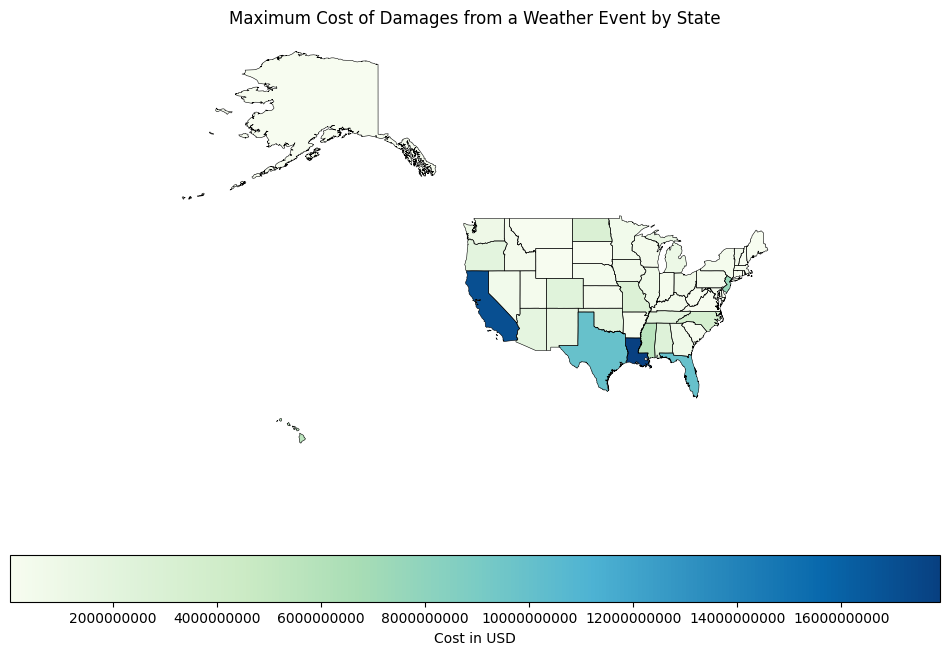

In [208]:
fig = plt.figure(1, figsize = (12,8))
ax = fig.add_subplot()
ax.set_axis_off()
plt.title('Maximum Cost of Damages from a Weather Event by State')
state_max_cost_map.plot(
    column='damage_cost',
    cmap='GnBu',
    linewidth = .4,
    ax = ax,
    legend=True,
    legend_kwds={"label": "Cost in USD", "orientation": "horizontal",'format':"%.0f"})
state_max_cost_map.boundary.plot(ax=ax, color='Black', linewidth=.4)

In [209]:
#state with highest total cost from weather events
state_total_cost = events_with_cost.groupby(['state',])['damage_cost'].sum().sort_values(ascending=False).reset_index()
print(state_total_cost.head())

         state     damage_cost
0        texas 118,570,966,450
1    louisiana  96,573,842,350
2      florida  71,281,452,390
3   california  36,039,064,310
4  mississippi  32,642,280,020


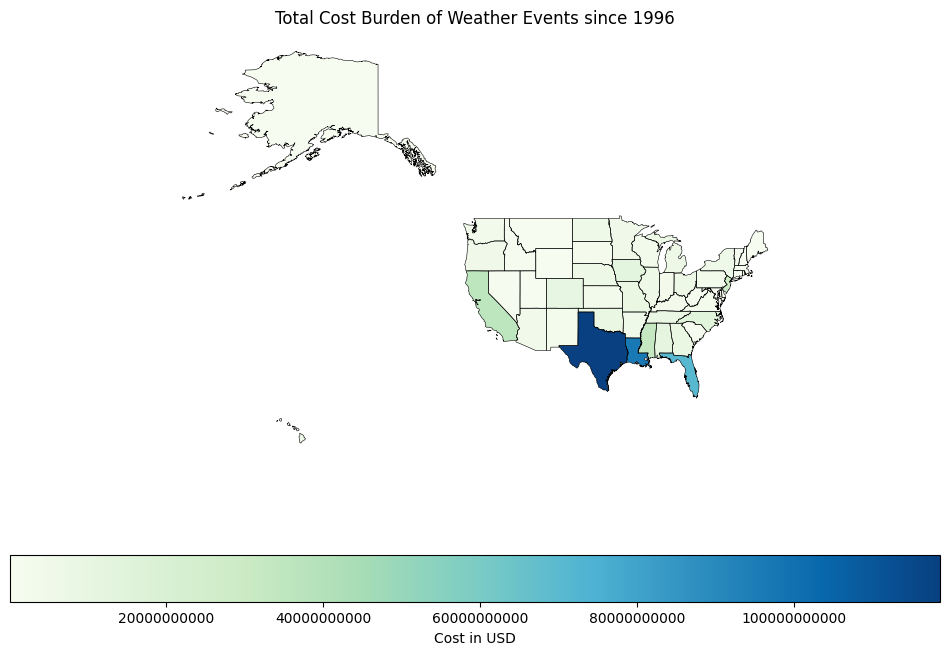

In [210]:
#create map of cost of damage burden by state from weather related events

state_total_cost_map = usa_map.merge(state_total_cost, on='state', how='inner')
fig = plt.figure(1, figsize = (12,8))
ax = fig.add_subplot()
ax.set_axis_off()
plt.title('Total Cost Burden of Weather Events since 1996')
state_total_cost_map.plot(
    column='damage_cost',
    cmap='GnBu',
    linewidth = .4,
    ax = ax,
    legend=True,
    legend_kwds={"label": "Cost in USD", "orientation": "horizontal",'format':"%.0f"})
state_max_cost_map.boundary.plot(ax=ax, color='Black', linewidth=.4)
plt.savefig('tot_cost_weather_bystate.png')